# CSINTSY MC01 - SokoBot Analyzer

## Authors:
- Campo, Roan
- David, Mo
- Go, Kenneth
- Lee, Rinaldo




# Preprocessing Modules
These are modules needed before running the analyzer.

Import the following modules:

In [110]:

import os
import math
import re
import warnings
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.widgets import Button

In [111]:
# Some settings to help filter the data.
warnings.filterwarnings('ignore')
pd.set_option('display.width', 1000)

Constants needed for the Analysis to work.

You many change the settings of graphs look here.

In [112]:
RESET_COLORS = "\033[0m" 

CSV_FILE = "result_tests.csv"

INFO_COLORS = {
    "test_name":        "#ff63b7", 
    "test_file":        "#ff6951", 
    "time_taken":       "#ff8800",
    "no_of_move":       "#fcaf00",
    "no_of_crates":     "#acd100",
    "has_bot_won":      "#00e75b",
    "solution":         "#00edc4",
    "width_of_map":     "#00e2ff",
    "height_of_map":    "#00caff",
    "number_of_blocks": "#82abff",
    "child_nodes_made": "#d98dff",
    "nodes_expanded":   "#ff74ff",
    "branching_factor": "#ea82ff",
    "map_density":      "#3ac3ff"
}

COLORS = {
    "RED" : "#FF0000",
    "GREEN": "#00FF00"
}

SIGNIFICANT_COLUMNS = ["no_of_crates", "no_of_moves", "time_taken", ""]

BASIS_STATS = {
    "Mean   :" : "mean",
    "Median :" : "median",
    "Max    :" : "max",
    "Min    :" : "min",
    "Sum    :" : "sum"
}

## Coloring and Visualization
These functions help with analyzing data in a much visually significant way.

Not only that, it makes them aesthetically pleasing in some sense.

In [113]:
# Colors text output of some functions.
def hex_to_rgb(hex_code: str) -> tuple[int, int, int]:
    """Turns hexcode to rgb

    Args:
        hex_code (str): hexcode that starts with #

    Returns:
        tuple(int, int, int): a tuple containing rgb information
    """
    hex_code = hex_code.lstrip('#')
    return tuple(int(hex_code[i:i + 2], 16) for i in (0, 2, 4))

def rgb_to_ansi_rgb(r, g, b):
    """Turns rgb values to ANSI escape codes

    Args:
        r (int): red
        g (int): green
        b (int): blue

    Returns:
        str: Equivalent Ansi Escape code.
    """
    return f"\033[38;2;{r};{g};{b}m"

def colored_text(hex_code) -> str:
    """colors text output 
    Args:
        hex_code (str): hexcode that starts with #

    Returns:
        str: Equivalent Ansi Escape code.
    """
    r, g, b = hex_to_rgb(hex_code)
    ansi_color = rgb_to_ansi_rgb(r, g, b)
    return ansi_color;

def rgb_to_hex(rgb: tuple[str, str, str]) -> str:
    """Generate a hexcode string from a rgb tuple

    Args:
        rgb (tuple[str, str, str]): 3-tuple representation of rgb values

    Returns:
        str: hexcode of the rgb values
    """
    return '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])

def mix_colors(hex_code1: str, hex_code2: str) -> str:
    """Mixes two colors together 

    Args:
        hex_code1 (str): string of color 1's hex code
        hex_code2 (str): string of color 2's hex code

    Returns:
        str: the mixed color's rgb code
    """
    # Unpack the RGB values
    r1, g1, b1 = hex_to_rgb(hex_code1)
    r2, g2, b2 = hex_to_rgb(hex_code2)
    
    # Average the RGB values
    mixed_color = (
        (r1 + r2) // 2, 
        (g1 + g2) // 2, 
        (b1 + b2) // 2
    )
    
    return rgb_to_hex(mixed_color)

def print_essay(essay: list[str]) -> None:
    """Concatenates a list of strings, then prints them in a single println statement.

    Args:
        essay (list[str]): List of sentences you want to output
    """
    output: str = str("");
    for sentence in essay:
        output += (sentence + '\n');
    print(output)

Some helpful functions that preprocess the dataframe. Convert some columns into useful data.

In [114]:
# Functions to preprocess the data.
def create_logs_of_colmn(df: pd.DataFrame, col_names: list[str]):
    """Create the logarithm of a list of column names

    Args:
        df (pd.DataFrame): dataframe to modify
        col_names (list[str]): list of strings to modify
    """
    for col_name in col_names:
        df["log_{}".format(col_name)] = df[col_name].agg(math.log)


def remove_seconds(input: str):
    """Used as an aggregate function to strip the seconds unit

    Args:
        input (str): numeric containing s at the end

    Returns:
        str: String with removed string unit
    """
    return input.rstrip("s"); 

def preprocess_df(df: pd.DataFrame) -> None:
    """Preprocesses dataframe for compatability. Turns the type of time_taken to float.

    Args:
        df (pd.DataFrame): _description_
    """
    df["time_taken"] = df["time_taken"].transform(remove_seconds)
    df["time_taken"] = df["time_taken"].astype(float);
    df["branching_factor"] = df["child_nodes_made"] / df["nodes_expanded"]
    df["map_density"] = df["number_of_blocks"] / (df ["width_of_map"] * df["height_of_map"])
    ## create_logs_of_colmn(df, [""])

def get_agg(df: pd.DataFrame, col: str, agg: str):
    return round(df[col].agg(agg), 3)

def sum_statistics(df: pd.DataFrame) -> None:
    for col, color in INFO_COLORS.items():
        print("\nStatistics of " + colored_text(color) + col + RESET_COLORS + ":")
        print("mean, median (min, max)\n{}, {} ({}, {})".format(get_agg(df, col, "mean"), get_agg(df, col, "median"), get_agg(df, col, "max"), get_agg(df, col, "min")) )


In [115]:
# Generates scatter plots
def generate_normal_scatter(df: pd.DataFrame, col_name: str):
    """Generates a pyplot scatter plot with the index as the x_axis and a column as the y_axis

    Args:
        df (pd.DataFrame): dataframe to inspect
        col_name (str): 
    """
    plt.scatter(df.index, df[col_name], color=INFO_COLORS[col_name], label=col_name)
    plt.xlabel("index") 
    plt.ylabel(col_name)
    plt.title("Statistic for {}".format(col_name))
    plt.grid()

def genenerate_tuple_scatter(df: pd.DataFrame, col_tuple: tuple[str, str]):
    """Generates a pyplot graph with the col_tuple[0] as the x_axis and col_tuple[1] as the y_axis

    Args:
        df (pd.DataFrame): _description_
        col_name (str): 
    """
    df.sort_values(col_tuple[0]);
    plt.scatter(df[col_tuple[0]], df[col_tuple[1]], color=mix_colors(INFO_COLORS[col_tuple[0]], INFO_COLORS[col_tuple[1]]))
    plt.xlabel(col_tuple[0]) 
    plt.ylabel(col_tuple[1])
    plt.title("Statistic for {} vs {}".format(col_tuple[0], col_tuple[1]))
    plt.grid()

# Analysis of Sokocat data
This portion deals with the analysis of the data that the tester produces on how.

Need to preprocess the dataframe. Separate them into two different groups: when the Sokobot won and successfully created a solution, and when the Sokobot lost and was timed out.

In [116]:
# Read the given CSV file within the same directory of the folder
df = pd.read_csv(CSV_FILE)

preprocess_df(df)
# Separate two different datasets
df_sucessful    = df[df["has_bot_won"] == True];
df_failed       = df[df["has_bot_won"] == False];

Let's have a view of the data at first glance.

In [117]:

# Print the first few rows
print("Review some sample data from the database.\n")
print(df.head())


Review some sample data from the database.

    test_name   test_file  time_taken  no_of_move  no_of_crates  has_bot_won                                           solution  width_of_map  height_of_map  number_of_blocks  child_nodes_made  nodes_expanded  branching_factor  map_density
0  fourboxes1  fourboxes1        0.12         104             4         True  lullulurrrlldddlurrrrdlluluurrdullddrdrruluull...             7              6                33              5834            4761          1.225373     0.785714
1   twoboxes3   twoboxes3        0.10          68             2         True  lulldrrddludruuulldrlurrdrdrrulllulldrdrrldluu...             8              6                28               519             410          1.265854     0.583333
2      stuck2      stuck2        0.06          18             2        False                                 No solution found.             7              7                29                 1               1          1.000000     0.591

## How many games can SokoCat the Sokobot win?
These are statistics that measure the likelihood for sokocat to find as solution within 15.0s. 

In [118]:
# Overall in most games.
essay_overall_wins = [
    "How many tests have sokobot won in General?",
    "{}Won{}      : {}".format(colored_text(COLORS["GREEN"]),  RESET_COLORS, str(df_sucessful.shape[0])),
    "{}Fail{}     : {}".format(colored_text(COLORS["RED"]), RESET_COLORS, str(df_failed.shape[0])),
    "---------+--------------------------------",
    "Win Rate : {}% of tests".format(str(round(df_sucessful.shape[0] / df.shape[0] * 100, 2)))
]

print_essay(essay_overall_wins)


How many tests have sokobot won in General?
Won      : 22
Fail     : 7
---------+--------------------------------
Win Rate : 75.86% of tests



In [119]:
essay_branching_factor = [
    "What is the estimated weighted average for the branching factor for sokobot?",
    "Branching factor: {}".format(round(df["branching_factor"].agg("mean"), 2))
]

print_essay(essay_branching_factor)

from IPython.display import display, Math

display(Math(r'B_{avg} = {%f}' % (round(df["branching_factor"].agg("mean"), 2))))


What is the estimated weighted average for the branching factor for sokobot?
Branching factor: 1.37



<IPython.core.display.Math object>

How does time to solve correlate with the number of crates?

In [120]:

print("Time taken to solve for each increase in the number of crates:")
df_sucessful.pivot_table(index="no_of_crates", values="time_taken", aggfunc=["mean", "min", "max"])

Time taken to solve for each increase in the number of crates:


,mean,min,max
,time_taken,time_taken,time_taken
no_of_crates,,,
1,0.070000,0.07,0.07
2,0.078333,0.06,0.11
3,0.152000,0.07,0.27
4,0.260000,0.11,0.45
5,0.573333,0.33,1.03
6,0.860000,0.54,1.18
11,0.580000,0.58,0.58


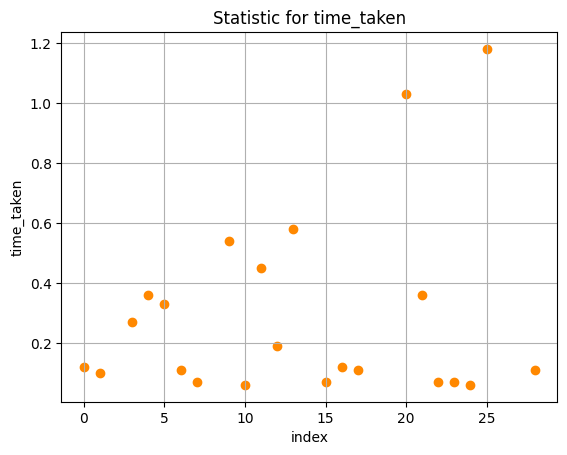

In [121]:
generate_normal_scatter(df_sucessful, "time_taken")

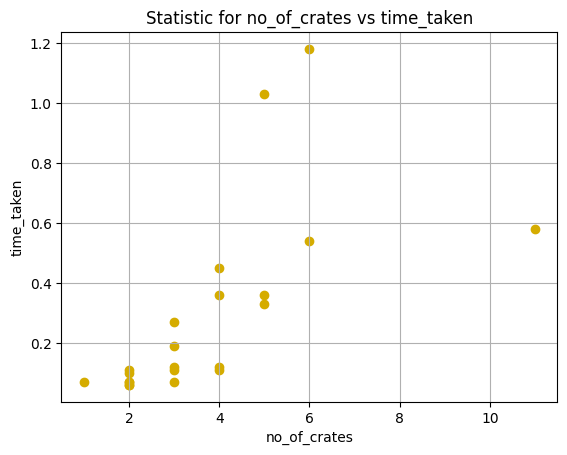

In [122]:
genenerate_tuple_scatter(df_sucessful, ("no_of_crates", "time_taken"))

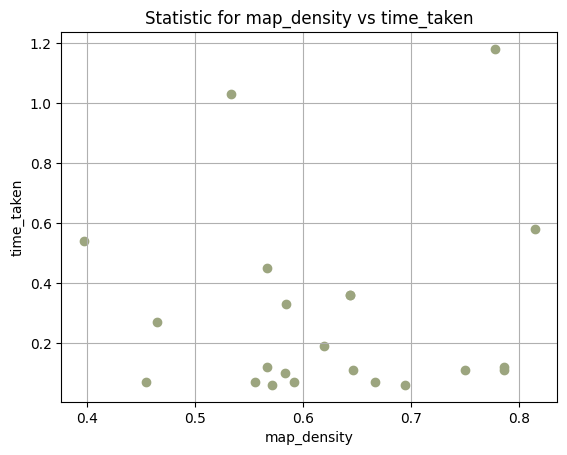

In [126]:
genenerate_tuple_scatter(df_sucessful, ("map_density", "time_taken"))

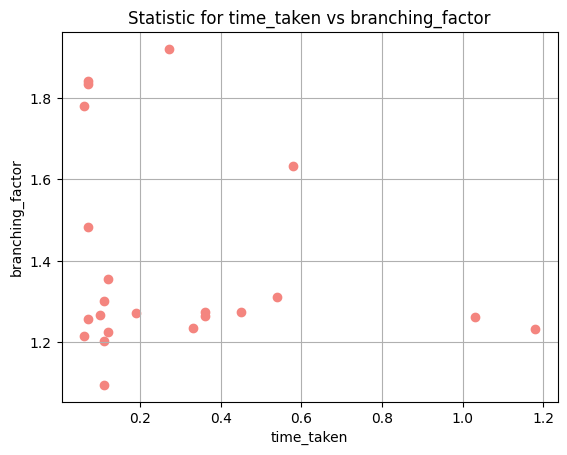

In [127]:
genenerate_tuple_scatter(df_sucessful, ("time_taken", "branching_factor"))

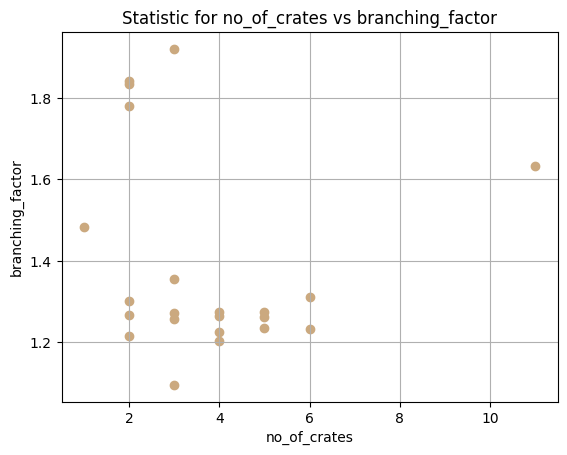

In [128]:
genenerate_tuple_scatter(df_sucessful, ("no_of_crates", "branching_factor"))

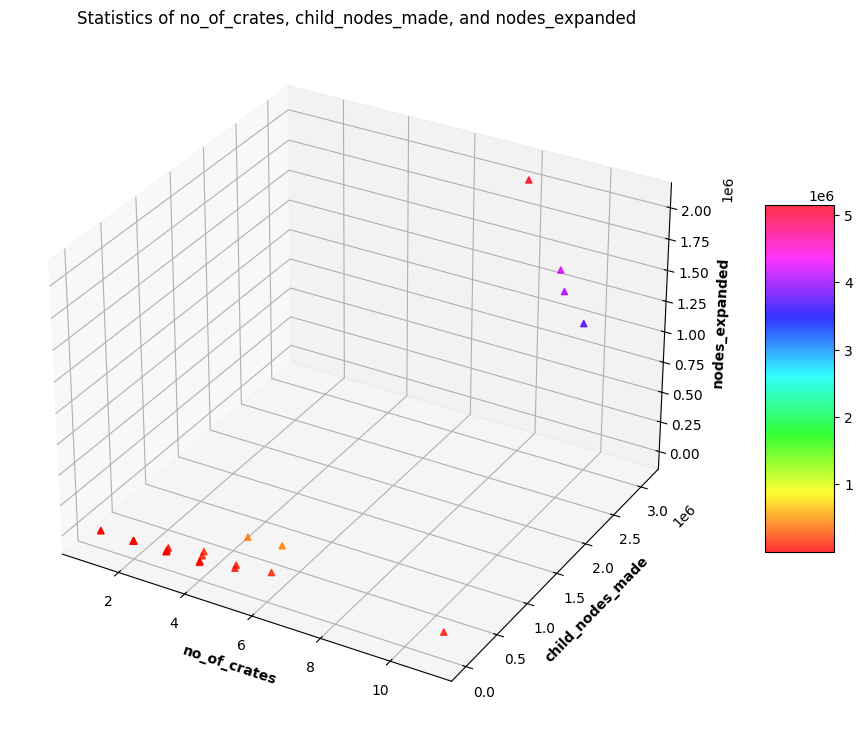

In [140]:
def generate_3d_scatter(df: pd.DataFrame, tuple_col: tuple[str, str, str]):
        x = df[tuple_col[0]]
        y = df[tuple_col[1]]
        z = df[tuple_col[2]]

        # Creating figure
        fig = plt.figure(figsize = (16, 9))
        ax = plt.axes(projection ="3d")
        
        # Add x, y gridlines 
        ax.grid(b = True, color ='grey', 
                linestyle ='-.', linewidth = 0.3, 
                alpha = 0.2) 
        

        # Creating color map
        my_cmap = plt.get_cmap('hsv')
        
        # Creating plot
        sctt = ax.scatter3D(x, y, z,
                        alpha = 0.8,
                        c = (x + y + z), 
                        cmap = my_cmap, 
                        marker ='^')
        
        plt.title("Statistics of {}, {}, and {}".format(tuple_col[0], tuple_col[1], tuple_col[2]))
        ax.set_xlabel(tuple_col[0], fontweight ='bold') 
        ax.set_ylabel(tuple_col[1], fontweight ='bold') 
        ax.set_zlabel(tuple_col[2], fontweight ='bold')
        fig.colorbar(sctt, ax = ax, shrink = 0.5, aspect = 5)
        
        # show plot
        plt.show()
generate_3d_scatter(df, ("no_of_crates", "child_nodes_made", "nodes_expanded"))